###Stage 2: Basic implementation 2 : Video compression

In [1]:
!pip install huffman

In [2]:
import collections
from PIL import Image
import numpy as np
import huffman
from scipy.fftpack import dct, idct
import cv2
from google.colab.patches import cv2_imshow


extracting 10 frames

In [3]:
video_path = "/content/drive/MyDrive/Image and video processing/Video/Moving Car.mp4"
video = cv2.VideoCapture(video_path)

frame_count = 0
frames=[]
while frame_count<10:
    success, frame = video.read()
    if not success:
        break

    # Check if the frame is empty
    if frame is None:
        continue

    # Save the frame as an image file
    cv2.imwrite(f"frame_{frame_count}.jpg", frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Display the frame
    #cv2_imshow(frame)
    cv2.waitKey(1)  # Add a small delay to display the frame (optional)
    frames.append(frame)
    frame_count += 1
frames=np.array(frames)
#print(frames.shape)
video.release()
cv2.destroyAllWindows()

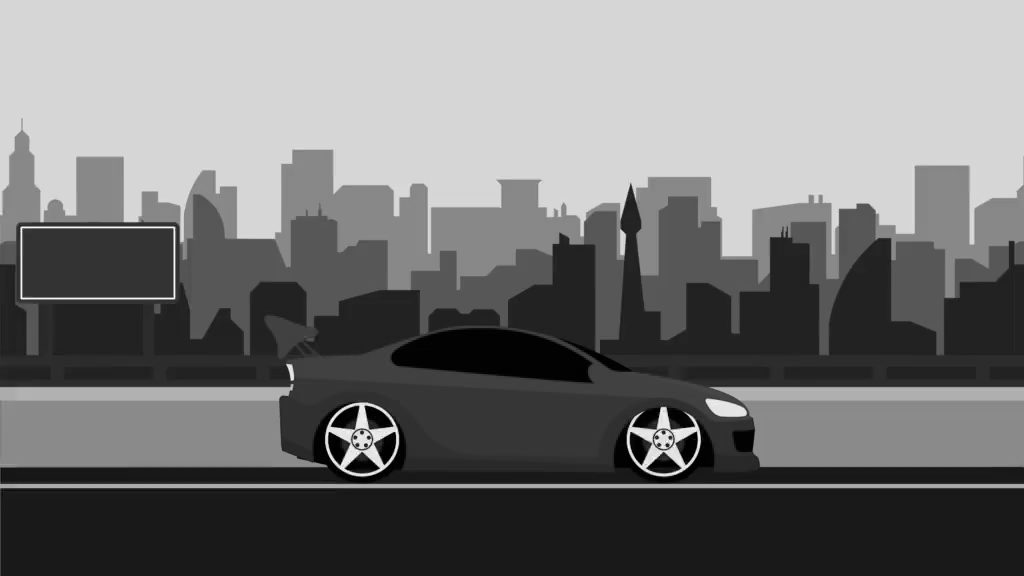

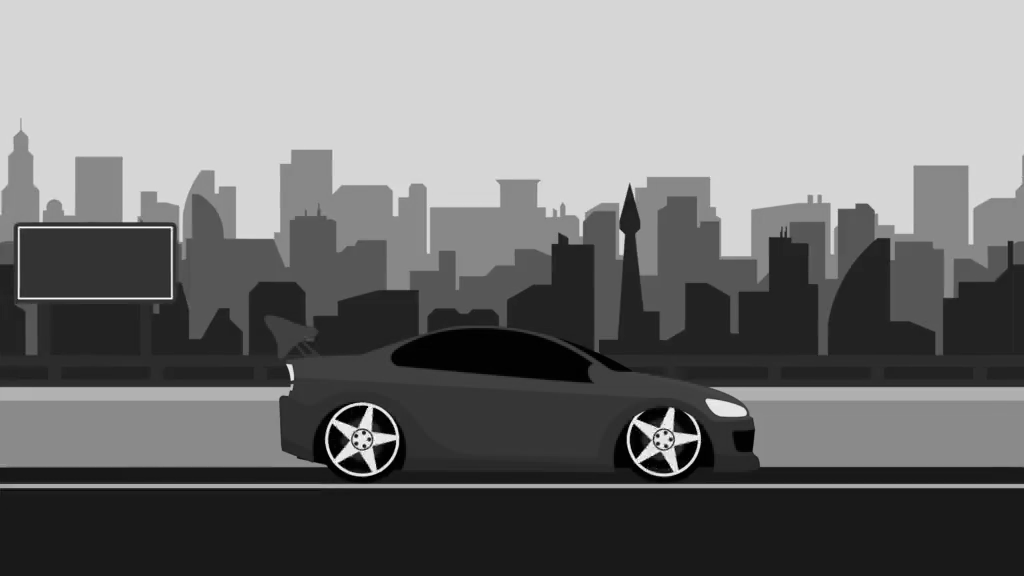

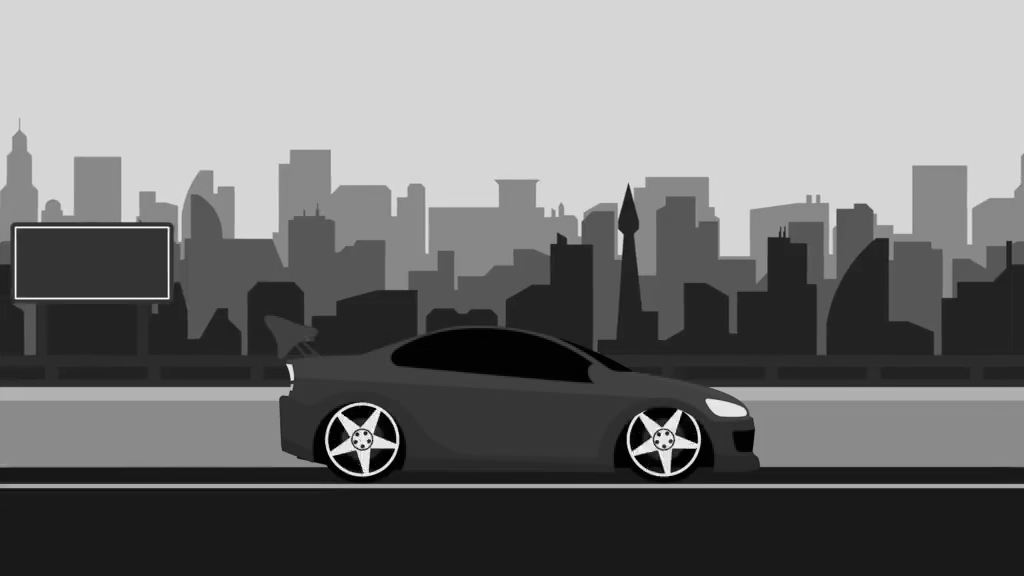

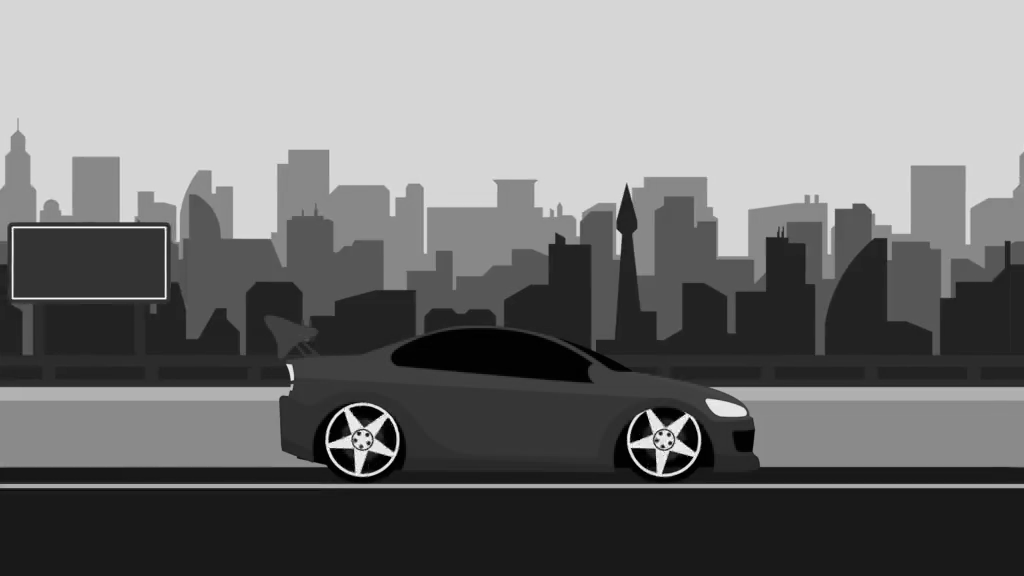

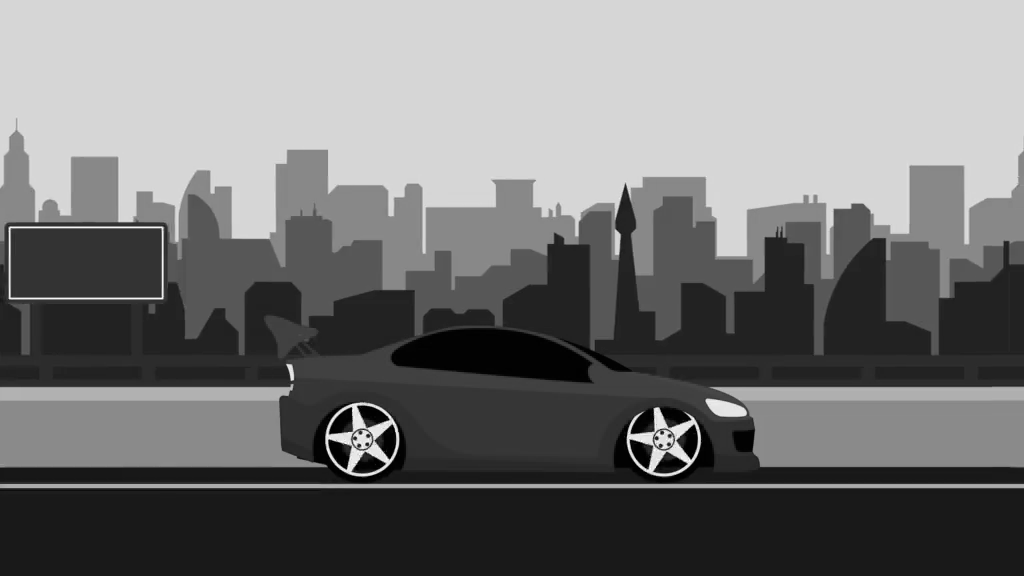

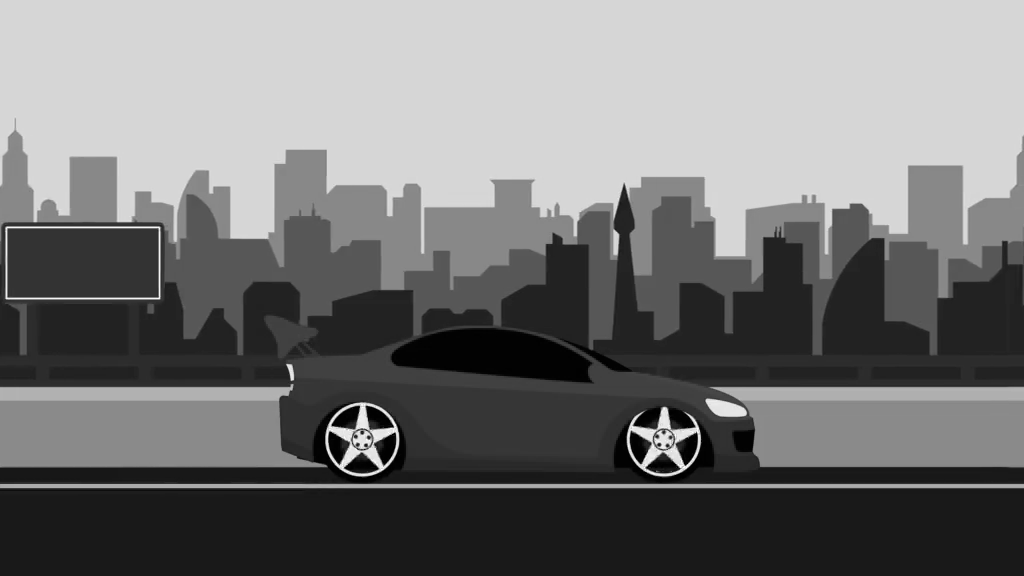

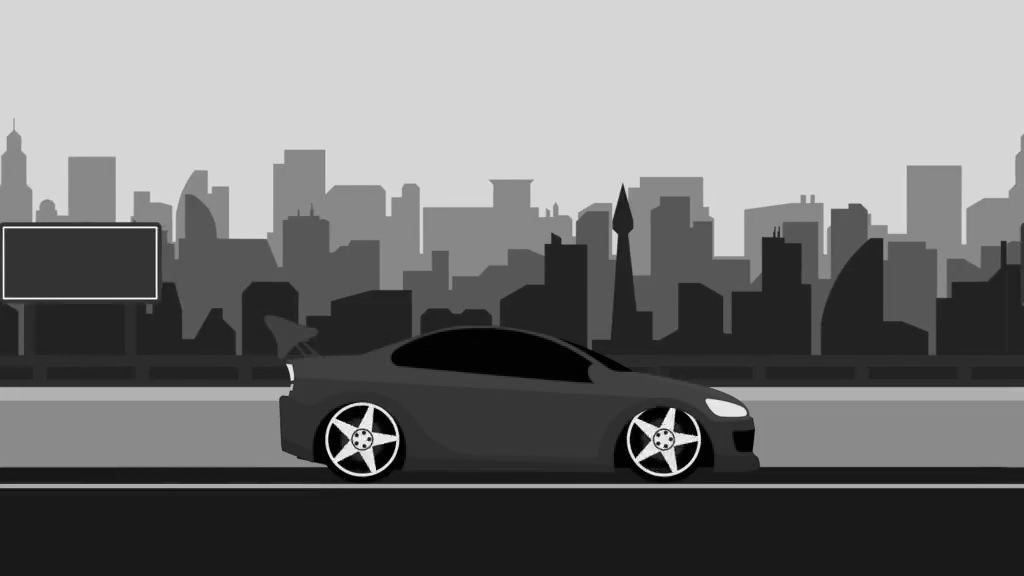

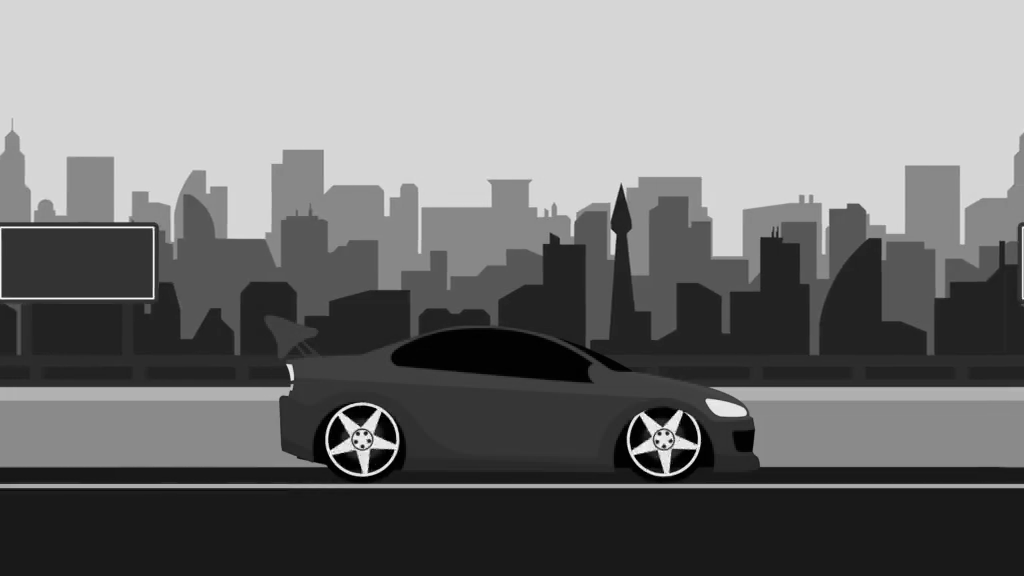

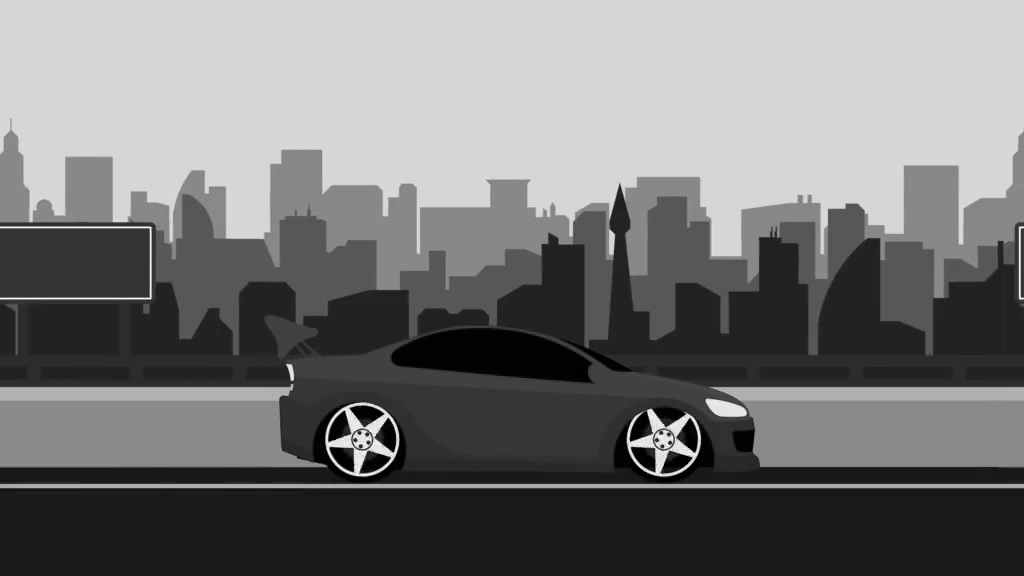

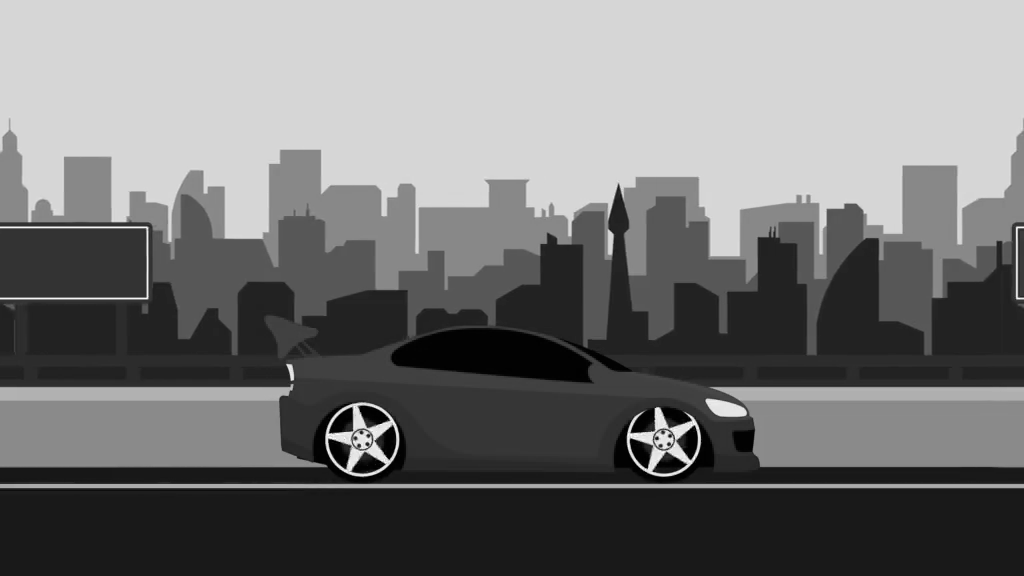

In [5]:
for i in range(10):
  cv2_imshow(frames[i])

image compression

In [6]:


def compress_image(img,q):
    # Load and prepare the image
    #img = Image.open(image_path).convert('L')
    pixels = np.array(img)

    def macro_blocks(image):
        # 8x8 macro blocks
        macro_blocks = []
        M, N = image.shape
        for i in range(0, M, 8):
            for j in range(0, N, 8):
                block = image[i:i+8, j:j+8]
                macro_blocks.append(block)
        return macro_blocks

    macro_blocks_list = macro_blocks(pixels)

    def apply_dct(macro_blocks):
        dct_blocks = []
        for block in macro_blocks:
            # Apply 2D DCT
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            dct_blocks.append(dct_block)
        return dct_blocks

    dct_blocks_list = apply_dct(macro_blocks_list)

    low = np.array([[4, 2, 2, 4, 8, 12, 16, 20],
                               [2, 2, 2, 4, 8, 12, 16, 16],
                               [2, 2, 4, 8, 12, 16, 16, 16],
                               [4, 4, 8, 12, 16, 16, 16, 16],
                               [8, 8, 12, 16, 16, 16, 16, 16],
                               [12, 12, 16, 16, 16, 16, 16, 16],
                               [16, 16, 16, 16, 16, 16, 16, 16],
                               [20, 16, 16, 16, 16, 16, 16, 16]])


    def quantization(dct_blocks, quantization_matrix,q):
        quantized_blocks = []
        for block in dct_blocks:
            # Apply quantization by dividing the DCT coefficients by the quantization matrix
            quantized_block = np.round(block / quantization_matrix/q)
            quantized_blocks.append(quantized_block.astype(int))
        quantized_coeffs = [coeff for block in quantized_blocks for row in block for coeff in row]
        return quantized_coeffs

    quantized_coeffs_list = quantization(dct_blocks_list, low,q)

    codebook = huffman.codebook(collections.Counter(quantized_coeffs_list).items())

    encode_list = [codebook[coeff] for coeff in quantized_coeffs_list]
    #encoded_values = ''.join(encode_list)

    '''with open("EncodedValues.txt", "w") as file:
        file.write(encoded_values)'''

    decode = [next(key for key, value in codebook.items() if value == code) for code in encode_list]
    '''if quantized_coeffs_list == decode:
        print('Decoding successful.')'''

    block_size = 8
    num_blocks = len(decode) // (block_size ** 2)
    reshaped_blocks = np.reshape(decode[:num_blocks * (block_size ** 2)], (num_blocks, block_size, block_size))

    def inverse_quantization(quantized_blocks, quantization_matrix,q):
        reconstructed_blocks = []
        for block in quantized_blocks:
            # Apply inverse quantization by multiplying the quantized coefficients with the quantization matrix
            reconstructed_block = block * quantization_matrix*q
            reconstructed_blocks.append(reconstructed_block)
        return reconstructed_blocks

    def apply_inverse_dct(reconstructed_blocks):
        inverse_dct_blocks = []
        for block in reconstructed_blocks:
            # Apply inverse DCT
            inverse_dct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')
            inverse_dct_blocks.append(inverse_dct_block)
        return inverse_dct_blocks

    inverse_quantized_blocks = inverse_quantization(reshaped_blocks, low,q)
    reconstructed_blocks = apply_inverse_dct(inverse_quantized_blocks)

    reconstructed_pixels = np.zeros_like(pixels)
    M, N = pixels.shape
    block_index = 0
    for i in range(0, M, 8):
        for j in range(0, N, 8):
            block = reconstructed_blocks[block_index]
            reconstructed_pixels[i:i+8, j:j+8] = block
            block_index += 1

    reconstructed_image = Image.fromarray(reconstructed_pixels)
    recons=np.array(reconstructed_image)
    #reconstructed_image.show()
    return encode_list,recons



In [7]:
encoded_ref,decoded_ref=compress_image(frames[0],0.1)

Motion Estimation

In [8]:


def motion_estimation(current_frame, reference_frame, block_size, search_range):
    height, width = current_frame.shape
    motion_vectors = np.zeros((height // block_size, width // block_size, 2))

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            min_sad = float('inf')
            best_mv = [0, 0]

            for m in range(-search_range, search_range+1):
                for n in range(-search_range, search_range+1):
                    if i+m < 0 or i+m+block_size > height or j+n < 0 or j+n+block_size > width:
                        continue

                    current_block = current_frame[i:i+block_size, j:j+block_size]
                    reference_block = reference_frame[i+m:i+m+block_size, j+n:j+n+block_size]

                    sad = np.sum(np.abs(current_block - reference_block))

                    if sad < min_sad:
                        min_sad = sad
                        best_mv = [m, n]

            mb_i, mb_j = i // block_size, j // block_size
            motion_vectors[mb_i, mb_j] = best_mv

    return motion_vectors


In [10]:
motion_vect=[]
ref_frame=frames[0]
for i in range(len(frames)):
  y=motion_estimation(frames[i],frames[0],8,16)
  motion_vect.append(y)


Encode motion vectors and store, then obtain decoded motion vectors

In [11]:
l=quantized_coeffs = [coeff for motion_vectors in motion_vect for block in motion_vectors for row in block for coeff in row]

codebook = huffman.codebook(collections.Counter(l).items())
enco_mv=[]
deco_mv=[]
for i in range(len(motion_vect)):
  g = [coeff for block in motion_vect[i] for row in block for coeff in row]
  emv=[codebook[coeff] for coeff in g]

  #decode stored motion vectors
  demv = [next(key for key, value in codebook.items() if value == code) for code in emv]
  reshaped_deco_mv = np.array(demv).reshape(72, 128, 2)
  enco_mv.append(emv)
  deco_mv.append(reshaped_deco_mv)



function to do motion compensation and obtain predicted frames(compensated frames)

In [12]:
def motion_compensation(reference_frame, motion_vectors, block_size):
    height, width = reference_frame.shape
    compensated_frame = np.zeros((height, width))

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            mv_i, mv_j = motion_vectors[i // block_size, j // block_size]
            mv_i = int(mv_i)
            mv_j = int(mv_j)

            if i+mv_i < 0 or i+mv_i+block_size > height or j+mv_j < 0 or j+mv_j+block_size > width:
                continue

            compensated_frame[i:i+block_size, j:j+block_size] = reference_frame[i+mv_i:i+mv_i+block_size, j+mv_j:j+mv_j+block_size]

    return compensated_frame


In [13]:
compensation=[]

for i in range(len(frames)):
  a=motion_compensation(frames[0],motion_vect[i],8)
  compensation.append(a)

function to obtain residual frames

In [14]:
def calculate_residual_frames(current_frame, compensated_frame):
    residual_frames = current_frame - compensated_frame
    return residual_frames


In [15]:
res_frames=[]
for i in range(len(frames)):
  r=calculate_residual_frames(frames[i],compensation[i])
  res_frames.append(r)

Encode residual frames and store, then obtain decoded values

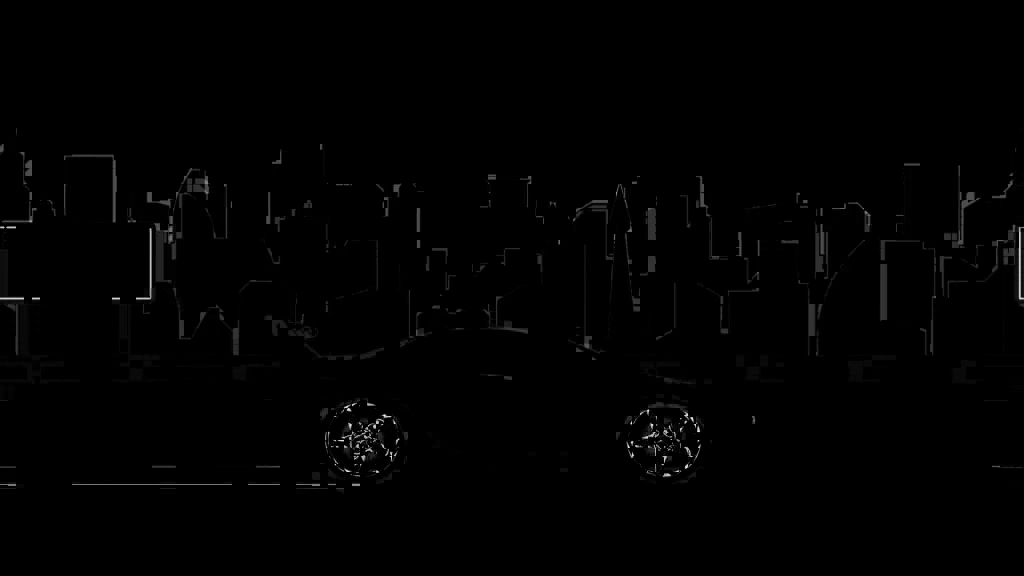

decoded residual frame


In [20]:
encoded_residuals=[]
decoded_residuals=[]
for i in range(len(res_frames)):
  en_res,de_res=compress_image(res_frames[i],0.1)
  encoded_residuals.append(en_res)
  decoded_residuals.append(de_res)
cv2_imshow(decoded_residuals[8])
print("decoded residual frame")

Do motion compensation using decoded referance frame and decoded motion vectors

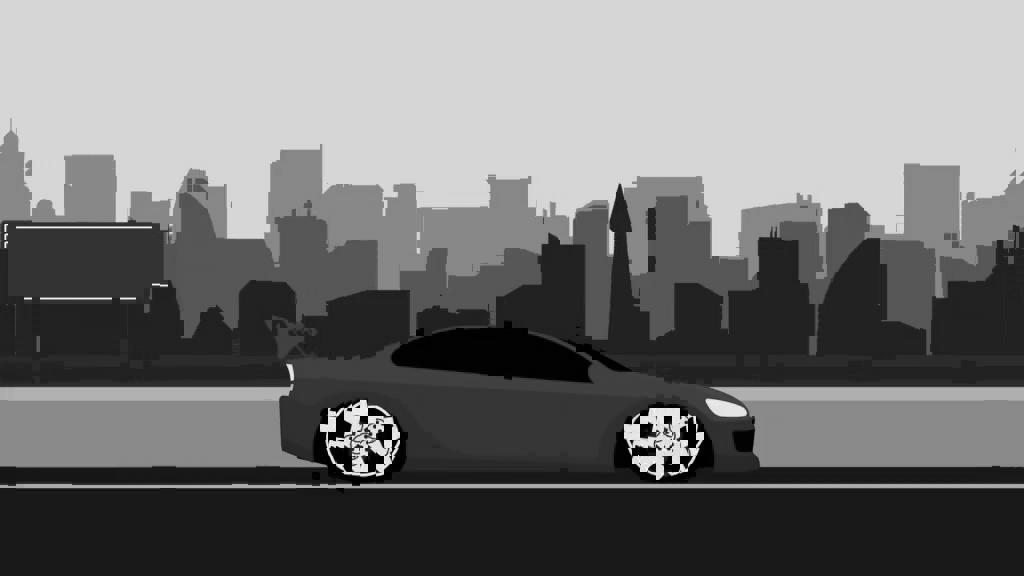

motion compensated frame


In [21]:

re_compensation=[]
for i in range(len(frames)):
  a=motion_compensation(decoded_ref,deco_mv[i],8)
  re_compensation.append(a)
cv2_imshow(re_compensation[8])
print("motion compensated frame")

reconstuct the original frames using obtained motion compensated frames and residual frames

In [22]:
def reconstruct_frames(compensated_frame, residual_frame):
    original_frame = compensated_frame + residual_frame
    return original_frame


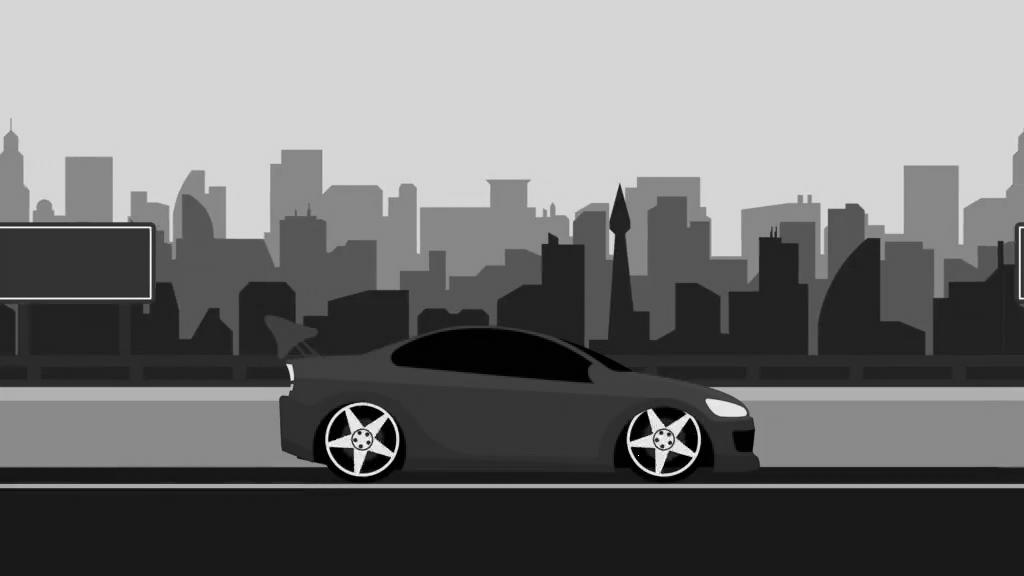

reconstructed frame


In [23]:
final_frames=[]
for i in range(len(frames)):
  v=reconstruct_frames(re_compensation[i],decoded_residuals[i])
  final_frames.append(v)
cv2_imshow(final_frames[8])
print("reconstructed frame")

Reconstructed frames

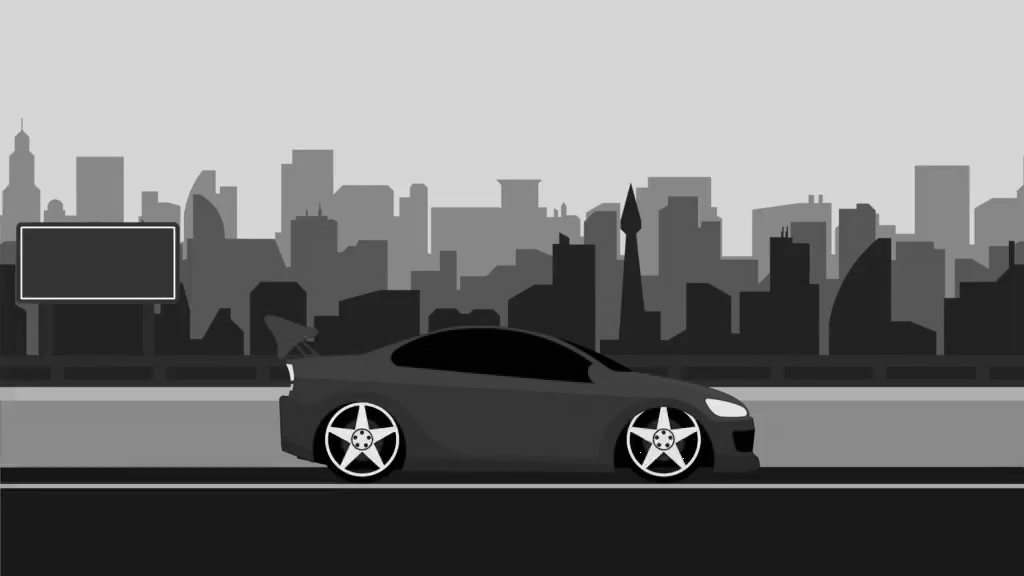

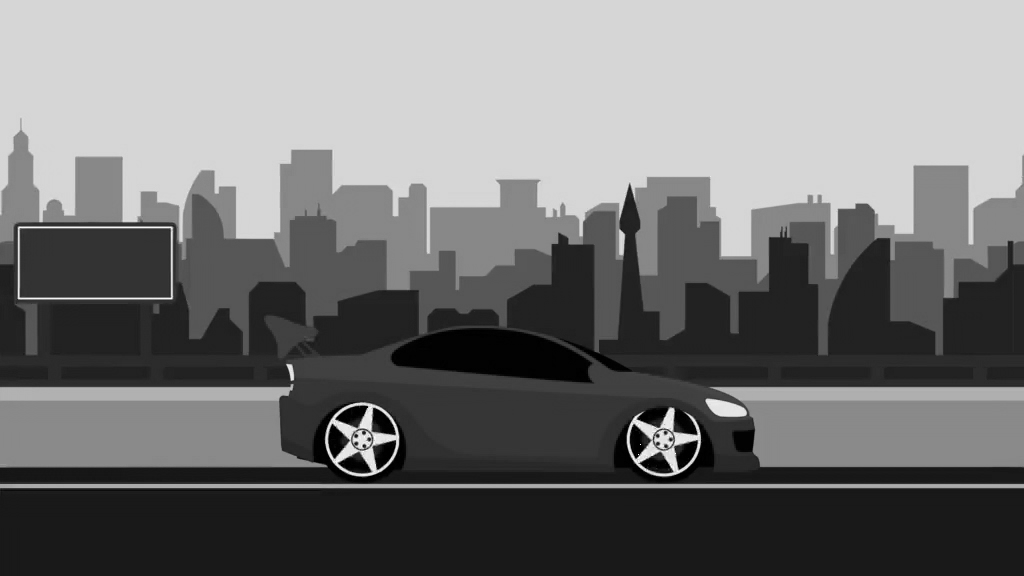

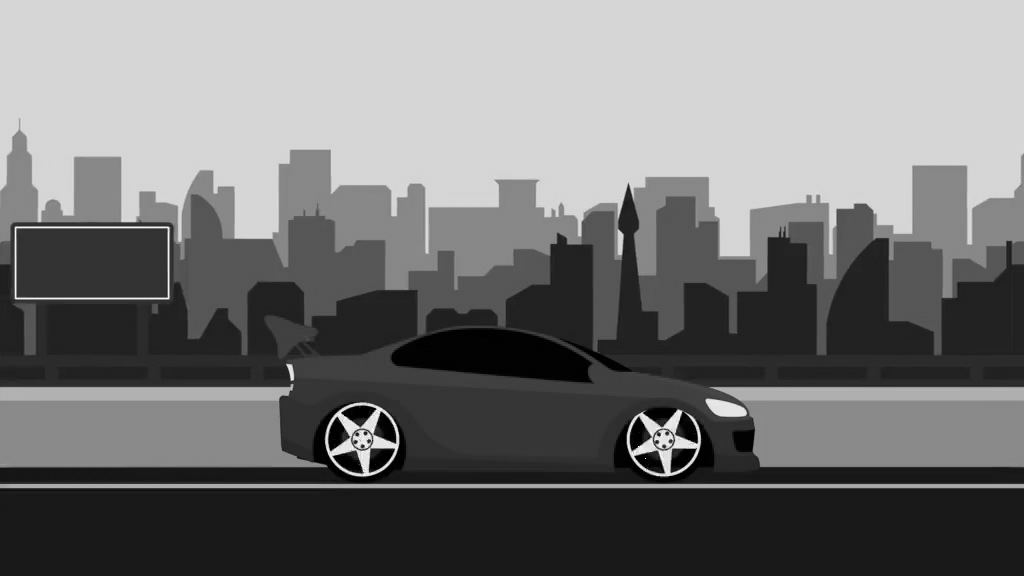

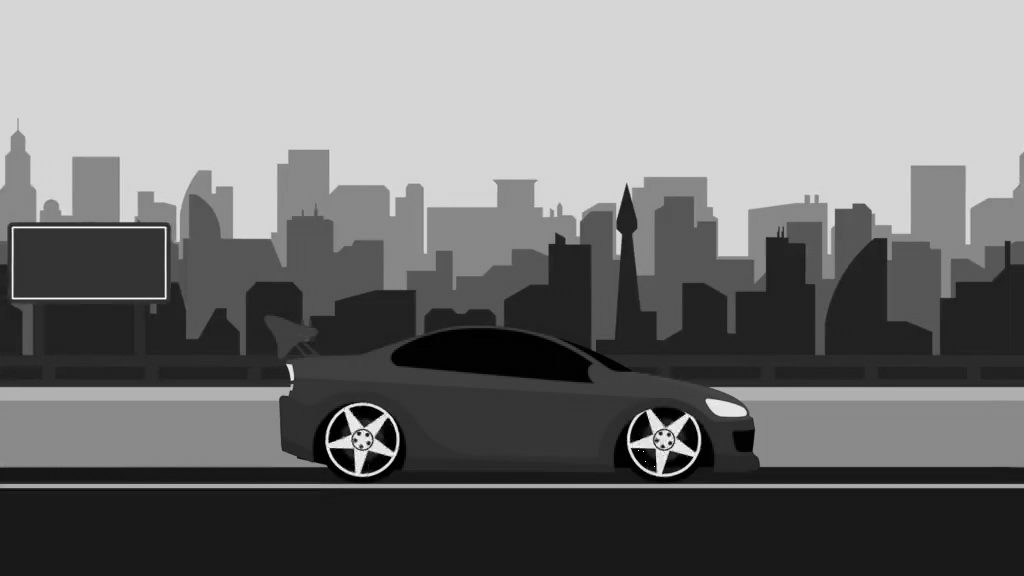

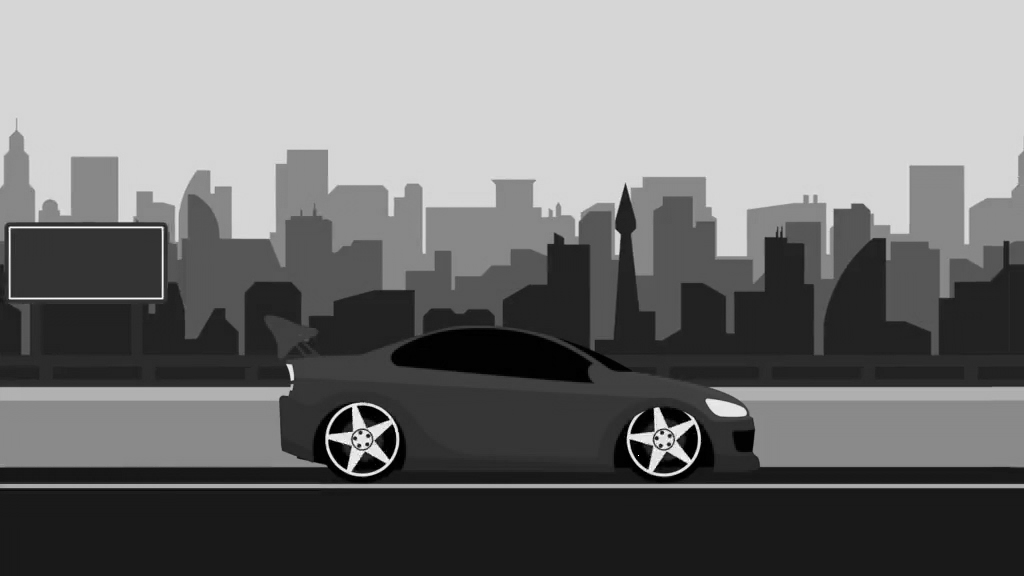

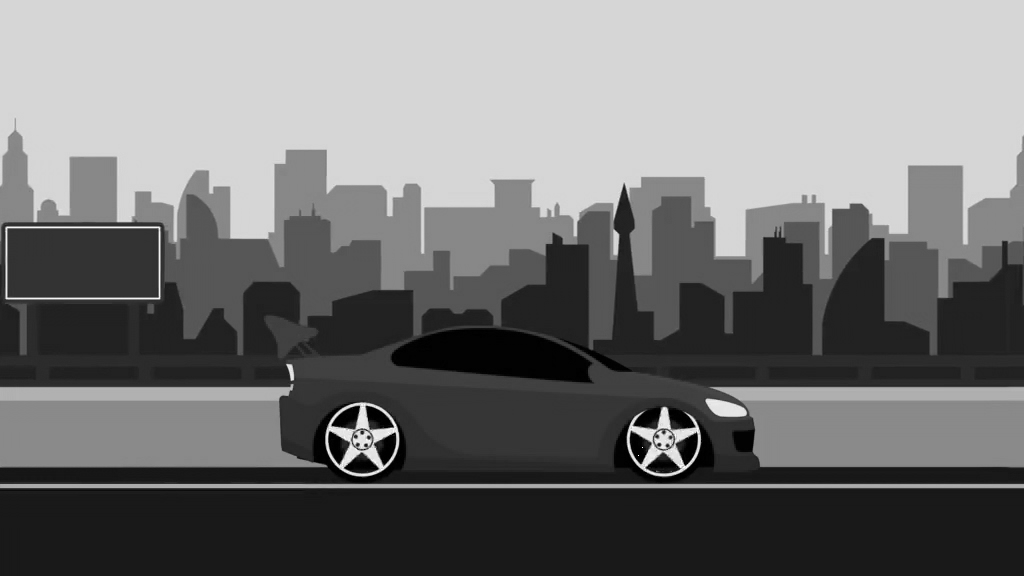

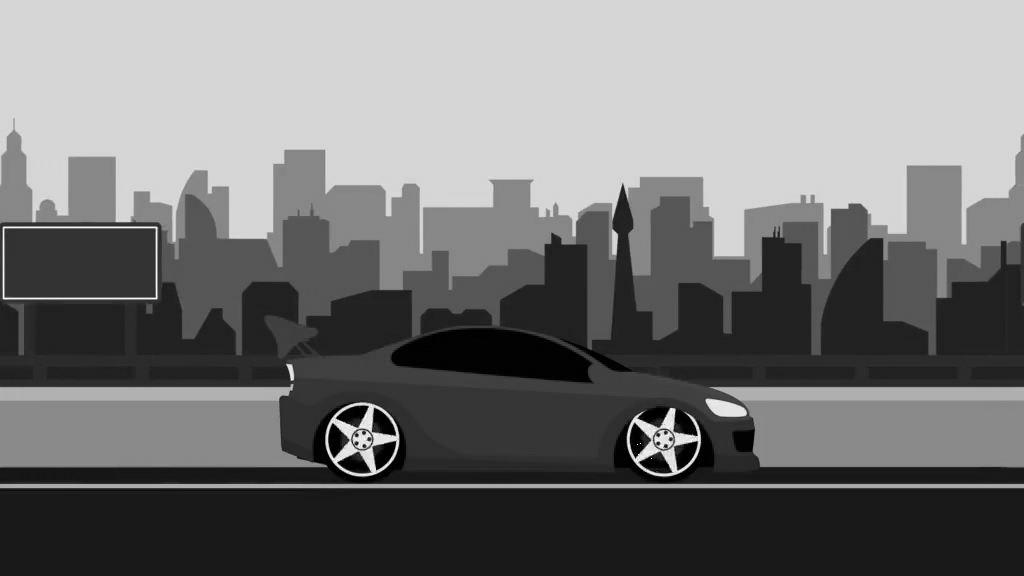

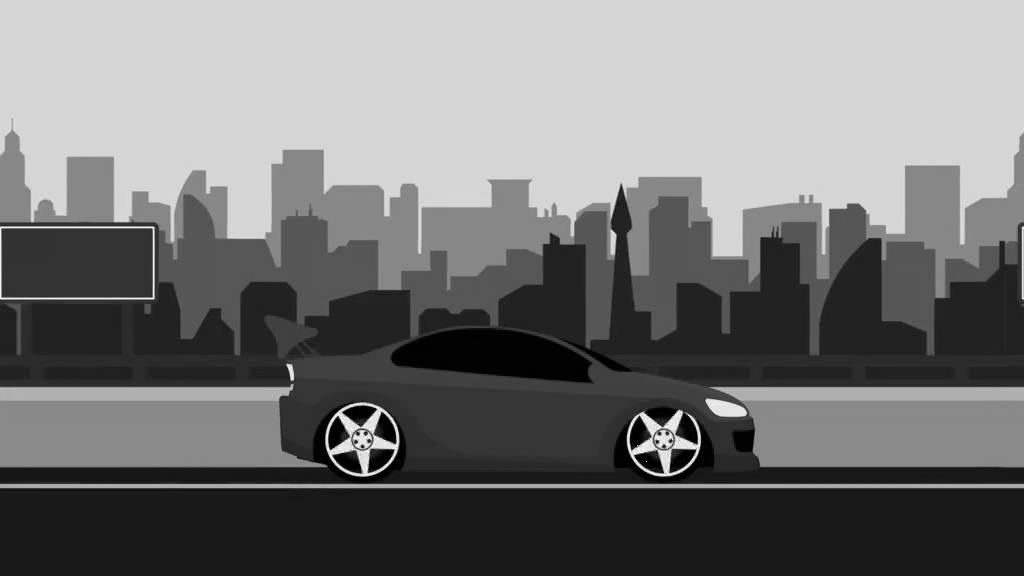

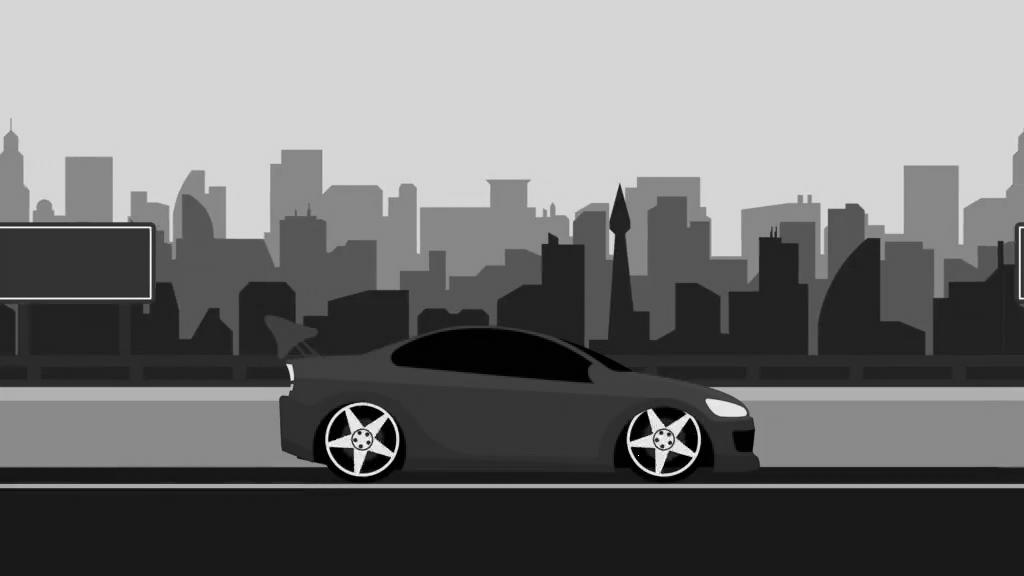

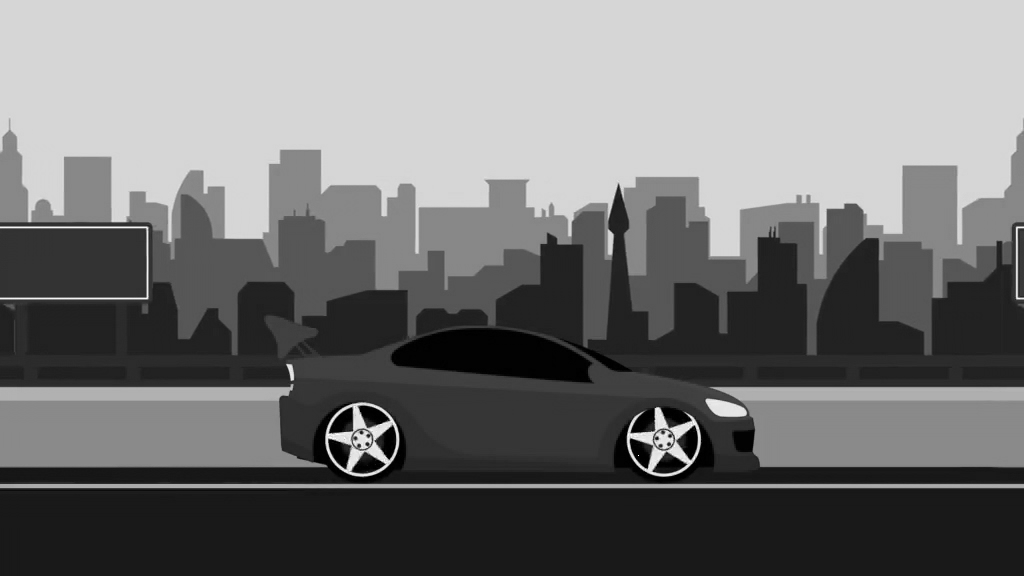

In [24]:
for i in range(len(frames)):
  cv2_imshow(final_frames[i])